In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import LogNorm
from itertools import chain, combinations, product

In [4]:
C = [('red', 'one'),
     ('blue', 'one'),
     ('red', 'two')]
U = ['red', 'blue', 'one', 'two']
P = np.array([1. / 3.] * 3)
M = np.zeros((len(U), len(C)))

# inverse temperature; how rational speaker is
alpha = 1.
# utterance cost function
kappa = np.array([0., 0., 0.])

# configure meaning function
for i, u in enumerate(U):
    for j, t in enumerate(C):
        M[i,j] = 1. if u in t else 0.

In [5]:
##### Listener Model ######
# literal listener
L_0 = M * P

# pragmatic speaker
S_1 = np.exp(alpha * (np.log(L_0) - kappa))

# pragmatic listener
L_2 = S_1 * P

/Users/mwalton/miniconda3/envs/plot/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log
  


assuming constant alpha = 1, kappa = 0 for all u

In [6]:
# Pragmatic Speaker
S_0 = M / np.sum(M, axis=0, keepdims=True)
L_1 = S_0 / np.sum(S_0, axis=1, keepdims=True)
S_2 = L_1 / np.sum(L_1, axis=0, keepdims=True)

# Pragmatic Listener
L_0 =  M / np.sum(M, axis=1, keepdims=True)
S_1 = L_0 / np.sum(L_0, axis=0, keepdims=True)
L_2 = S_1 / np.sum(S_1, axis=1, keepdims=True)

S_2

array([[0.5       , 0.        , 0.33333333],
       [0.        , 0.66666667, 0.        ],
       [0.5       , 0.33333333, 0.        ],
       [0.        , 0.        , 0.66666667]])

# Hanabi RSA

In [2]:
class HanabiDeck(object):
    def __init__(self):
        self.n = 50
        self.F = ('r', 'g', 'b', 'w', 'y')
        self.V = (1, 2, 3, 4, 5)
        self.nu = {1: 3, 2: 2, 3: 2, 4: 2, 5: 1}
        self.ids, self.counts = self._init_counts()
        self.num_cards = 5

    def _init_counts(self):
        p = []
        ids = []

        for i, c in enumerate(self.F):
            for j, v in enumerate(self.V):
                multiplicity = self.nu[v]
                p.append(multiplicity)
                ids.append(c + str(v))
        return ids, np.array(p)

    def sample(self, num_cards=5):
        p = self.p()
        hand = []
        for _ in range(num_cards):
            hand.append(np.random.choice(self.ids, p=p[:(len(self.F) * len(self.V))]))
        return np.array(hand)

    def p(self, context=None):
        ''' returns the 'contextual prior' over possible hands
        given context (other player's hand) '''
        if context is None:
            p = self.counts / np.sum(self.counts)
            return np.tile(p, self.num_cards)
        else:
            mod_counts = self.counts
            for c in context:
                selected = [i for i, id in enumerate(self.ids) if id == c]
                mod_counts[selected] = mod_counts[selected] - 1
            return np.tile(mod_counts / (self.n - len(context)), self.num_cards)

    def meaning_function(self, context=[]):
        power_set = self.powerset(range(self.num_cards))
        # ASF: Should this remove cards entirely if given in context or should it remove only if none remain in the
        #      set of available cards? RSA seems to assume there aren't duplicates
        color_to_str = {'r': 0, 'g': 1, 'b':2, 'w':3, 'y':4}
        m = (len(self.F) + len(self.V)) * (2**self.num_cards - 1)
        n = self.num_cards * len(self.F) * len(self.V)
        M = np.zeros(shape=(m, n))
        for c_ind, (label, subset) in enumerate(product(self.F + self.V, power_set)):
            print(label, subset)
            for ind in subset:
                if type(label) == str:
                    for i in range(5):
                        M[c_ind][(25 * ind) + (5 * color_to_str[label]) + i] = 1
                else:
                    offset = 0
                    for i in self.nu.keys():
                        if i == label:
                            break
                        offset += self.nu[i]
                    for i in range(5):
                        M[c_ind][(25 * ind) + (5 * i) + label - 1] = 1

        return M

    def powerset(self, set_in):
        s = list(set_in)
        res_list = list(chain.from_iterable(combinations(s, r) for r in range(len(s) + 1)))
        return res_list[1:] if len(res_list) > 0 else []


def pragmatic_agent(M, P, k, type):
    if type == 'listener':
        norm = [0, 1]
    elif type == 'speaker':
        norm = [1, 0]
    else:
        raise ValueError("No such agent type")

    deltas = []

    psi = M * P
    for i in range(1, k + 1):
        new_psi = psi / np.sum(psi, axis=norm[0], keepdims=True)
        new_psi = new_psi / np.sum(new_psi, axis=norm[1], keepdims=True)
        deltas.append(np.sum(np.abs(new_psi - psi), axis=1))
        psi = new_psi

    return psi, deltas

In [3]:
deck = HanabiDeck()
hand = deck.sample()
print("example hand: {}".format(hand))

example hand: ['w1' 'g1' 'b1' 'w1' 'w1']


In [8]:
M = deck.meaning_function()
P = deck.p()
L, delta_L = pragmatic_agent(M, P, 20, 'listener')
S, delta_S = pragmatic_agent(M, P, 20, 'speaker')

r (0,)
r (1,)
r (2,)
r (3,)
r (4,)
r (0, 1)
r (0, 2)
r (0, 3)
r (0, 4)
r (1, 2)
r (1, 3)
r (1, 4)
r (2, 3)
r (2, 4)
r (3, 4)
r (0, 1, 2)
r (0, 1, 3)
r (0, 1, 4)
r (0, 2, 3)
r (0, 2, 4)
r (0, 3, 4)
r (1, 2, 3)
r (1, 2, 4)
r (1, 3, 4)
r (2, 3, 4)
r (0, 1, 2, 3)
r (0, 1, 2, 4)
r (0, 1, 3, 4)
r (0, 2, 3, 4)
r (1, 2, 3, 4)
r (0, 1, 2, 3, 4)
g (0,)
g (1,)
g (2,)
g (3,)
g (4,)
g (0, 1)
g (0, 2)
g (0, 3)
g (0, 4)
g (1, 2)
g (1, 3)
g (1, 4)
g (2, 3)
g (2, 4)
g (3, 4)
g (0, 1, 2)
g (0, 1, 3)
g (0, 1, 4)
g (0, 2, 3)
g (0, 2, 4)
g (0, 3, 4)
g (1, 2, 3)
g (1, 2, 4)
g (1, 3, 4)
g (2, 3, 4)
g (0, 1, 2, 3)
g (0, 1, 2, 4)
g (0, 1, 3, 4)
g (0, 2, 3, 4)
g (1, 2, 3, 4)
g (0, 1, 2, 3, 4)
b (0,)
b (1,)
b (2,)
b (3,)
b (4,)
b (0, 1)
b (0, 2)
b (0, 3)
b (0, 4)
b (1, 2)
b (1, 3)
b (1, 4)
b (2, 3)
b (2, 4)
b (3, 4)
b (0, 1, 2)
b (0, 1, 3)
b (0, 1, 4)
b (0, 2, 3)
b (0, 2, 4)
b (0, 3, 4)
b (1, 2, 3)
b (1, 2, 4)
b (1, 3, 4)
b (2, 3, 4)
b (0, 1, 2, 3)
b (0, 1, 2, 4)
b (0, 1, 3, 4)
b (0, 2, 3, 4)
b (1, 2, 3, 4)
b (0

Text(0.5, 0, 'Recursion depth')

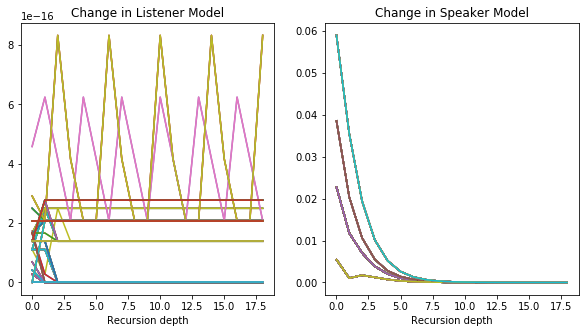

In [9]:
fig, ax = plt.subplots(1,2,figsize=(10,5))
ax[0].plot(delta_L[1:])
ax[0].set_title("Change in Listener Model")
ax[0].set_xlabel("Recursion depth")
ax[1].plot(delta_S[1:])
ax[1].set_title("Change in Speaker Model")
ax[1].set_xlabel("Recursion depth")